# Data Stories: A Tourist's trip in Lisbon

This section is focused on the analysis of a trip of the standard tourist in Lisbon.

We'll start by importing some dependencies:

In [285]:
# database connection library + database information
from db_configs import host, database, user, password
import psycopg2 as pg

# data manipulation libraries
import pandas as pd
import geopandas as gpd 
from shapely.geometry import Point # convert coordinates to points
import numpy as np
from datetime import datetime

# data visualization libraries
import plotly.graph_objs as go
import plotly
import cufflinks as cf # Cufflinks binds plotly to pandas dataframes in IPython notebook.
import matplotlib.pyplot as plt
import seaborn as sns # for color palettes

cf.set_config_file(offline=False, world_readable=True, theme='pearl')

# to create visualizations gifs
import glob
import os

# Turn on retina mode and set configurations
from IPython.display import set_matplotlib_formats
import IPython

set_matplotlib_formats('retina')
%matplotlib inline
plotly.offline.init_notebook_mode()
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# connect to the database
connection = pg.connect(host=host, dbname=database, user=user, password=password)

viz_out = 'plotly_viz/'

We know from the basic data analysis that the most common tourist visiting Lisbon in the month of August is French. So, we will define our target tourist as French and is visiting Lisbon in August. As 23% of tourists arrive on a Tuesday, and the second day of August 2017 with the maximum number of French tourists is on the 12th (Saturday) and the average length of stay of these tourists is of 8 days, the tourist must be in Lisbon on the 12th and have a length of stay around the mentioned average. We will consider the most common day of week of departure for our tourist: Wednesday, which corresponds to August 16th and a date of arrival August 8th (Tuesday), being also the most common day of arrival.


Found a couple: ( 7382845 + 4273113)
- Arrival date: 8th
- Departure date: 16th
- First contact was in Lisbon (Implying he came by plane)
- Visiting Lisbon

Found a solo tourist: 6826968
- Arrival date: 8th
- Departure date: 12th
- First contact was in Lisbon (Implying he came by plane)
- Visiting Lisbon



Next: ir buscar um grupo de 3 ou uma pessoa sozinha que tenha vindo no mesmo avião mas tenha ficado por pouco tempo e comparar os seus percursos



**Dizer que ele alugou um Airbnb e analizar a sua estadia com dados de Airbnb também?**



In [2]:
french_story = pd.read_sql_query("SELECT * FROM telecom_pt.viz_data_stories_test",con=connection)

def number_of_days_as_float(val):
    return val.days+val.seconds/86400

french_story['stay_days'] = french_story['average_length_of_stay'].apply(number_of_days_as_float)

french_story = french_story[french_story['arrival_distrito']=='Lisboa']

days_of_stay = (french_story['stay_days']*french_story['count_arrival_concelho']).sum() / french_story['count_arrival_concelho'].sum()

days_of_stay

8.0130033956945859

## Getting the events for the tourist pair

In [286]:
query = """
select
    union_all.enddate as event_date,
    extract(day from union_all.enddate) as day_of_month,
    extract(hour from union_all.enddate) as hour_of_day,
    extract(minute from union_all.enddate) as minute_of_hour,
    union_all.client_id,
    uniques_mcc.mnew_country as origin,
    concat(cast(union_all.cell_id as varchar(16)),cast(cast(union_all.lac as int) as varchar(16)),cast(cast(union_all.protocol as int) as varchar(16))) as cell_ref,
    label,
    centroide_latitude,
    centroide_longitude,
    distrito,
    concelho,
    municipio
from telecom_pt.union_all

left join (select distinct(cast(mccmnc.mmcc as varchar(16))) as mcc, mnew_country from telecom_pt.mccmnc) as uniques_mcc
on substring(cast(union_all.mccmnc as varchar(16)),1,3)=uniques_mcc.mcc
left join (
        select distinct(
                concat(cast(ci as varchar(16)),cast(cast(lac as int) as varchar(16)),cast(cast(protocol_ as int) as varchar(16)))
                        ) as cell_ref,
                region_labels.municipio,
                region_labels.distrito,
                region_labels.concelho,
              cellid_anchors.cellid as label,
              site_lookup.centroide_latitude, site_lookup.centroide_longitude
            from telecom_pt.site_lookup
            left join telecom_pt.cellid_anchors
            on concat(cast(ci as varchar(16)),cast(cast(lac as int) as varchar(16)),cast(cast(protocol_ as int) as varchar(16)))=cast(cellid_anchors.cellid2 as varchar(16))
            left join telecom_pt.region_labels
            on concat(cast(ci as varchar(16)),cast(cast(lac as int) as varchar(16)),cast(cast(protocol_ as int) as varchar(16))) = cast(region_labels.cell_id as varchar(16))
            ) as nodes_anchors
on concat(cast(union_all.cell_id as varchar(16)),cast(cast(union_all.lac as int) as varchar(16)),cast(cast(union_all.protocol as int) as varchar(16)))=cast(nodes_anchors.cell_ref as varchar(16))
where client_id in (7382845, 4273113) order by enddate asc
"""

In [287]:
couple_story = pd.read_sql_query(query,con=connection)[['event_date','client_id','centroide_latitude','centroide_longitude']]#,'distrito', 'concelho','municipio','label',]]
couple_story = couple_story[~couple_story['centroide_latitude'].isnull()]
couple_story = couple_story[~couple_story['client_id'].isnull()]
couple_story = couple_story.drop_duplicates()
couple_story['client_id'] = couple_story['client_id'].astype(int)
#couple_story['event_date'] = pd.to_datetime(couple_story['event_date'])
couple_story['day'] = couple_story['event_date'].dt.day
couple_story['hour'] = couple_story['event_date'].dt.hour
couple_story['minute'] = couple_story['event_date'].dt.minute


shp_dir = '/home/jfonseca/tourism_proj/pt_regions_shapefiles/'
portugal = gpd.read_file(shp_dir+'gadm36_PRT.gpkg')\
            .rename(columns={'NAME_0':'country','NAME_1':'distrito', 'NAME_2':'concelho', 'NAME_3':'municipio' })\
            [['country','distrito','concelho','municipio','geometry']]


# limit area to Lisbon region
portugal = portugal[portugal['concelho'].isin(['Lisboa','Oeiras','Cascais','Amadora','Odivelas','Loures','Sintra','Almada'])]
concelhos = portugal[['concelho', 'geometry']].dissolve(by='concelho').reset_index()

# upsample data
def add_zero_and_format(val):
    if val<10:
        return '0'+str(int(val))
    else:
        return str(int(val))

couple_story = couple_story.groupby(['client_id', 'day', 'hour', 'minute']).mean().reset_index()
couple_story['date_str'] = pd.to_datetime('2017-08-'+couple_story['day'].apply(add_zero_and_format)\
                                                +' '+couple_story['hour'].apply(add_zero_and_format)+':'\
                                                    +couple_story['minute'].apply(add_zero_and_format)+':00')

couple_story = couple_story[['client_id', 'date_str','centroide_latitude','centroide_longitude']]
couple_story = couple_story.set_index('date_str')
couple_story = couple_story.groupby('client_id').resample('1T', fill_method='pad')#.asfreq().interpolate('linear')
couple_story = couple_story[['centroide_latitude','centroide_longitude']].reset_index()
couple_story = couple_story[['date_str','centroide_latitude','centroide_longitude']].groupby('date_str').mean()

In [288]:
def pd_to_gpd(df):
    geometry = [Point(xy) for xy in zip(df.centroide_longitude, df.centroide_latitude)]
    df  = df.drop(['centroide_longitude', 'centroide_latitude'], axis=1)
    crs = {'init': 'epsg:4326'}
    return gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

couple_story = pd_to_gpd(couple_story).reset_index()
#couple_story


In [ ]:
def generate_frames(df, bg, directory, gif_name, alpha=1):
    
    iteration = 1
    
    def add_zero_and_format(val):
        if val<10:
            return '0'+str(int(val))
        else:
            return str(int(val))
    
    
    days = [add_zero_and_format(x) for x in list(range(min(couple_story['date_str']).day,max(couple_story['date_str']).day+1))]
    
    hours   = [add_zero_and_format(x) for x in list(range(24))]
    #minutes = [add_zero_and_format(x) for x in list(range(60))]
    
    #hours   = ['07', '8']
    minutes = ['05']
    
    total_iterations = len(days)*len(hours)*len(minutes)
    
    for day in days:
        for hour in hours:
            for minute in minutes:
                try:
                    side_length = 12
                    fig, ax1 = plt.subplots(ncols=1, figsize=(side_length, side_length), 
                                            sharex=True, sharey=True)

                    # Plot
                    bg.plot(ax=ax1, color='white', edgecolor='black')
                    df[df['date_str'] == '2017-08-%s %s:%s:00' % (day, hour, minute)] \
                                    .plot(ax=ax1, marker='o', color=['red'], markersize=60, alpha=alpha)

                    ax1.set_title('Data Story: A tourist in Lisbon', fontdict={'fontsize': 20, 'fontweight' : 3})
                    ax1.annotate('%s August 2017, %sh%sm' % (day,hour,minute), xy=(0.4, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=16, color='#555555')
                    ax1.axis('off')
                    print('Completion:',str("{0:.2f}".format((iteration/total_iterations)*100.0))+'%')
                    iteration+=1
                    plt.savefig(fname=directory+'flows_%s_story.png' % str(iteration), format='png')
                    plt.close()
                    
                except TypeError as e:
                    plt.close()
                    #print(e)
                    continue
                
    
    print('Generating GIF...')
    file_list = glob.glob(directory+'*.png') # Get all the pngs in the current directory
    list.sort(file_list, key=lambda x: int(x.split('_')[3].split('.png')[0])) # Sort the images by #, this may need to be tweaked for your use case
    
    with open('image_list.txt', 'w') as file:
        for item in file_list:
            file.write("%s\n" % item)
    
    os.system('convert @image_list.txt {}.gif'.format(gif_name))
    os.system('rm {}'.format('image_list.txt'))
    




# configure the generation of the visualization


generate_frames(couple_story, concelhos, 'frames_data_story/', 'data_stories_flows', alpha=1)

iframe = '<iframe src=' + 'data_stories_flows' + '.gif' + ' width=100% height=750px></iframe>'
IPython.display.HTML(iframe)

Completion: 0.52%
Completion: 1.04%
Completion: 1.56%
Completion: 2.08%
Completion: 2.60%
Completion: 3.12%
Completion: 3.65%
Completion: 4.17%
Completion: 4.69%
Completion: 5.21%
Completion: 5.73%
Completion: 6.25%
Completion: 6.77%
Completion: 7.29%
Completion: 7.81%
Completion: 8.33%
Completion: 8.85%
Completion: 9.38%
Completion: 9.90%
Completion: 10.42%
Completion: 10.94%
Completion: 11.46%
Completion: 11.98%
Completion: 12.50%
Completion: 13.02%
Completion: 13.54%
Completion: 14.06%
Completion: 14.58%
Completion: 15.10%
Completion: 15.62%
Completion: 16.15%
Completion: 16.67%
Completion: 17.19%
Completion: 17.71%
Completion: 18.23%
Completion: 18.75%
Completion: 19.27%
Completion: 19.79%
Completion: 20.31%
Completion: 20.83%
Completion: 21.35%
Completion: 21.88%
Completion: 22.40%
Completion: 22.92%
Completion: 23.44%
Completion: 23.96%
Completion: 24.48%
Completion: 25.00%
Completion: 25.52%
Completion: 26.04%
Completion: 26.56%
Completion: 27.08%
Completion: 27.60%
Completion: 

## Per municipality visits

In [291]:
couple = pd.read_sql_query(query,con=connection)

couple['rel_day'] = (couple['day_of_month'] - min(couple['day_of_month'])+1).astype(int)
couple = couple[couple['municipio']!=None]
couple['municipio_from'] = couple['municipio'].shift(1)
couple['municipio_to'] = couple['municipio']
couple['arrival_date'] = couple['event_date']

couple = couple[couple['municipio_from']!=couple['municipio_to']][['client_id', 'rel_day','municipio_from', 'municipio_to']]
couple = couple[couple['municipio_from']!=None][couple['municipio_to']!=None]
couple['municipio'] = couple['municipio_to']
couple = couple[['rel_day','municipio']]

shp_dir = '/home/jfonseca/tourism_proj/pt_regions_shapefiles/'
portugal = gpd.read_file(shp_dir+'gadm36_PRT.gpkg')\
            .rename(columns={'NAME_0':'country','NAME_1':'distrito', 'NAME_2':'concelho', 'NAME_3':'municipio' })\
            [['country','distrito','concelho','municipio','geometry']]


# limit area to Lisbon region
portugal = portugal[portugal['concelho'].isin(['Lisboa','Oeiras','Cascais','Amadora','Odivelas','Loures','Sintra','Almada'])]\
            [['municipio','geometry']]

couple = portugal.merge(couple, on='municipio', how='right')
couple['rel_day2'] = couple['rel_day']
couple = couple.set_index('rel_day')


In [292]:

couple.index.unique()


Int64Index([5, 7, 1, 6, 2, 3, 4, 8], dtype='int64', name='rel_day')

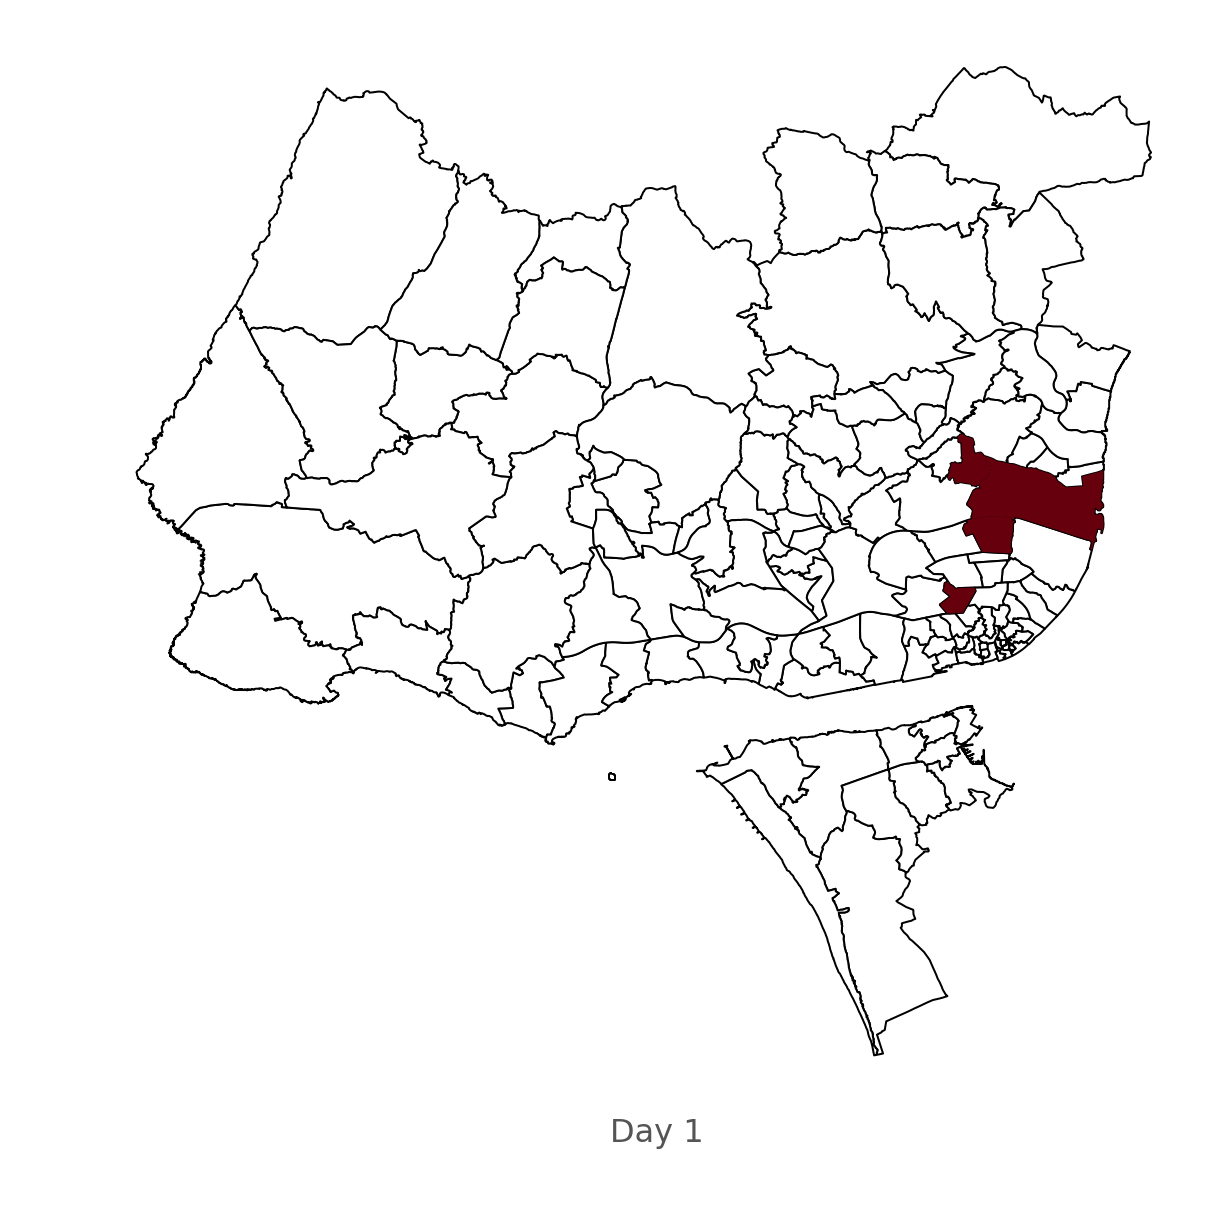

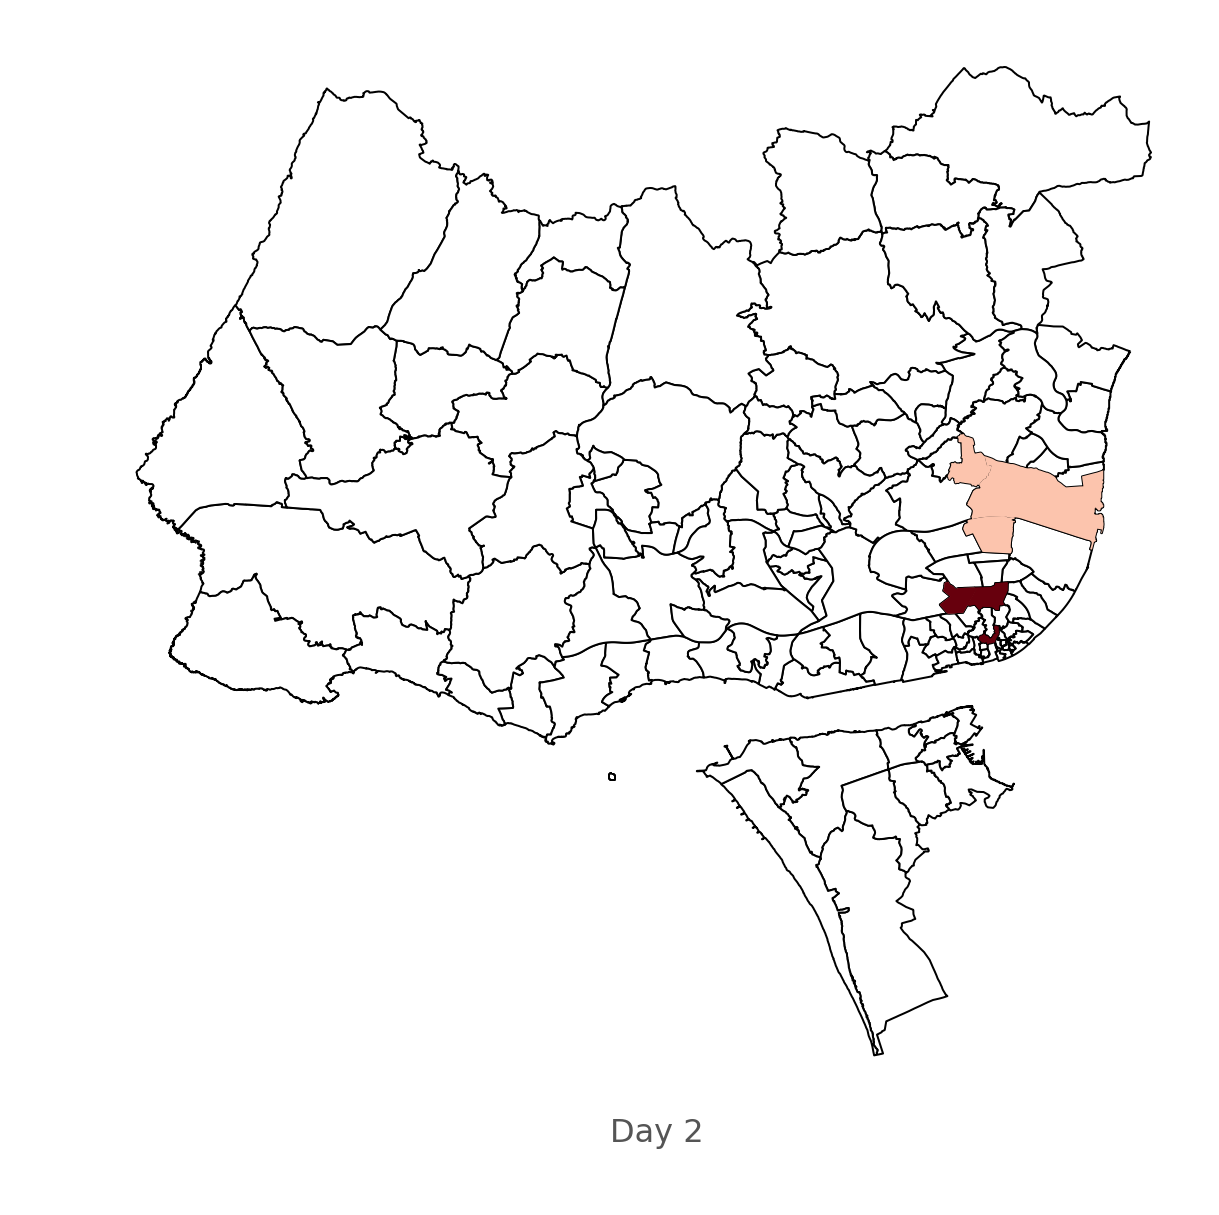

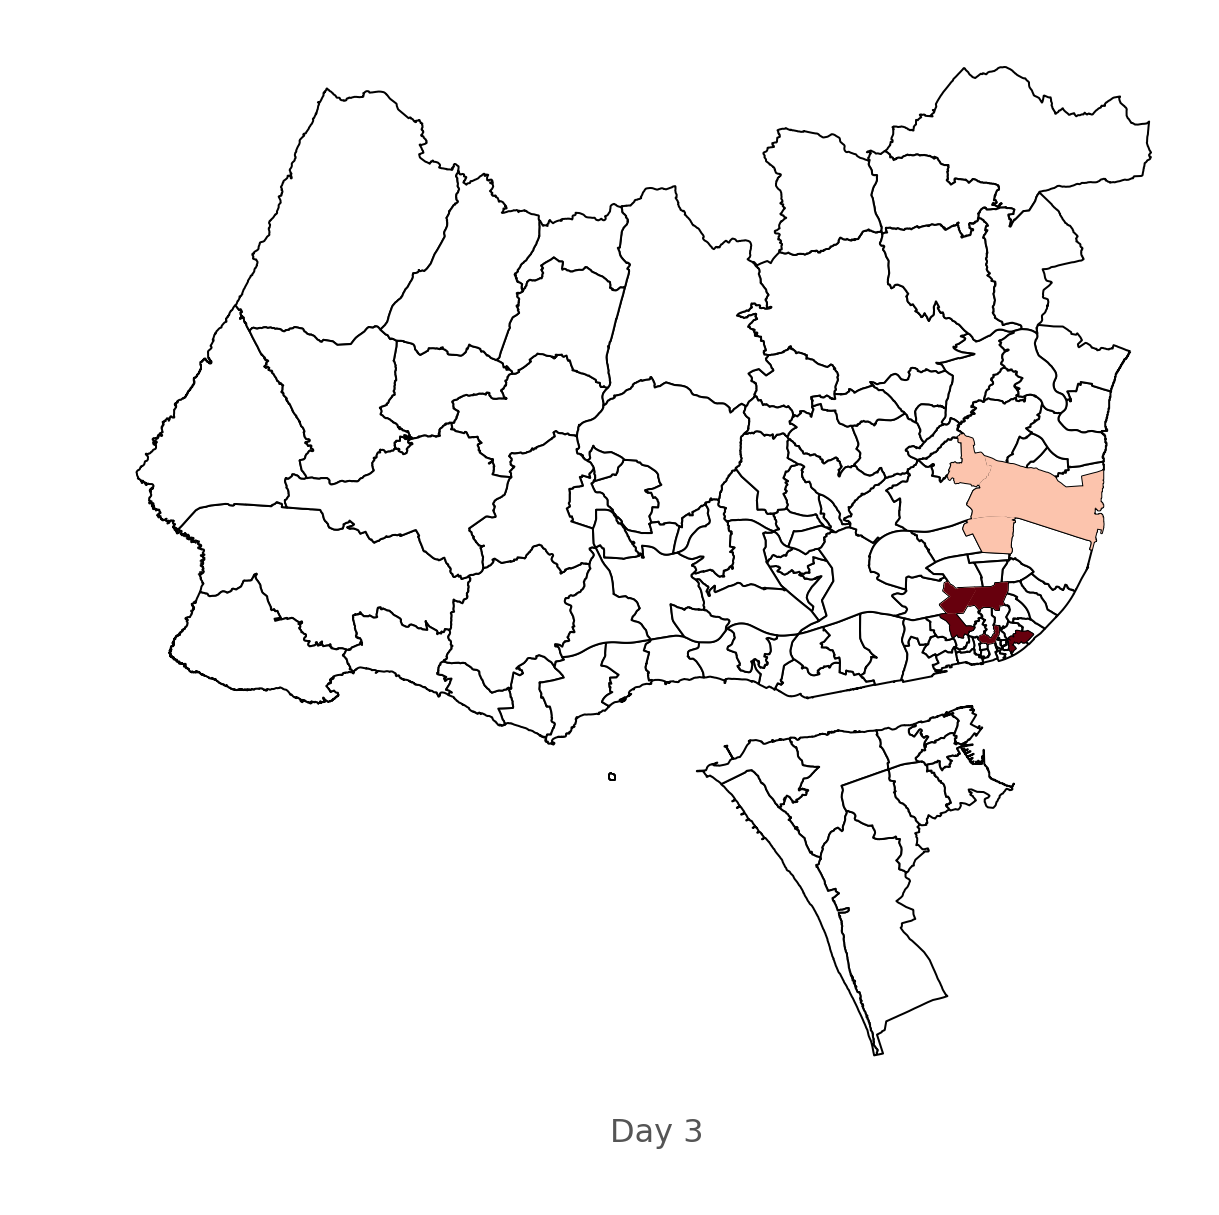

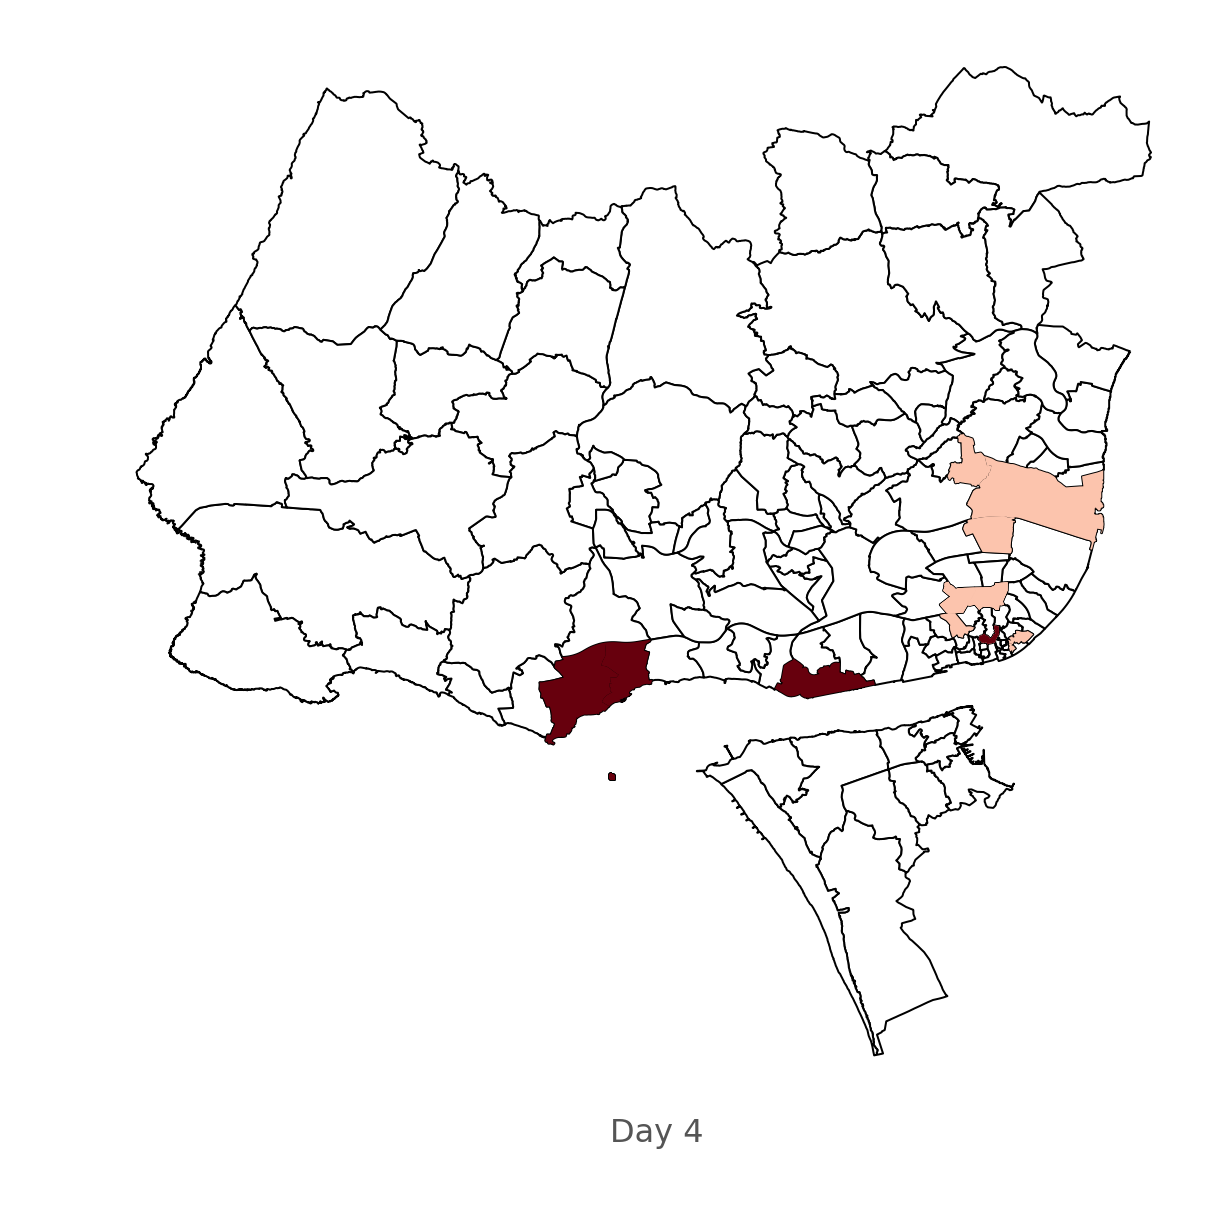

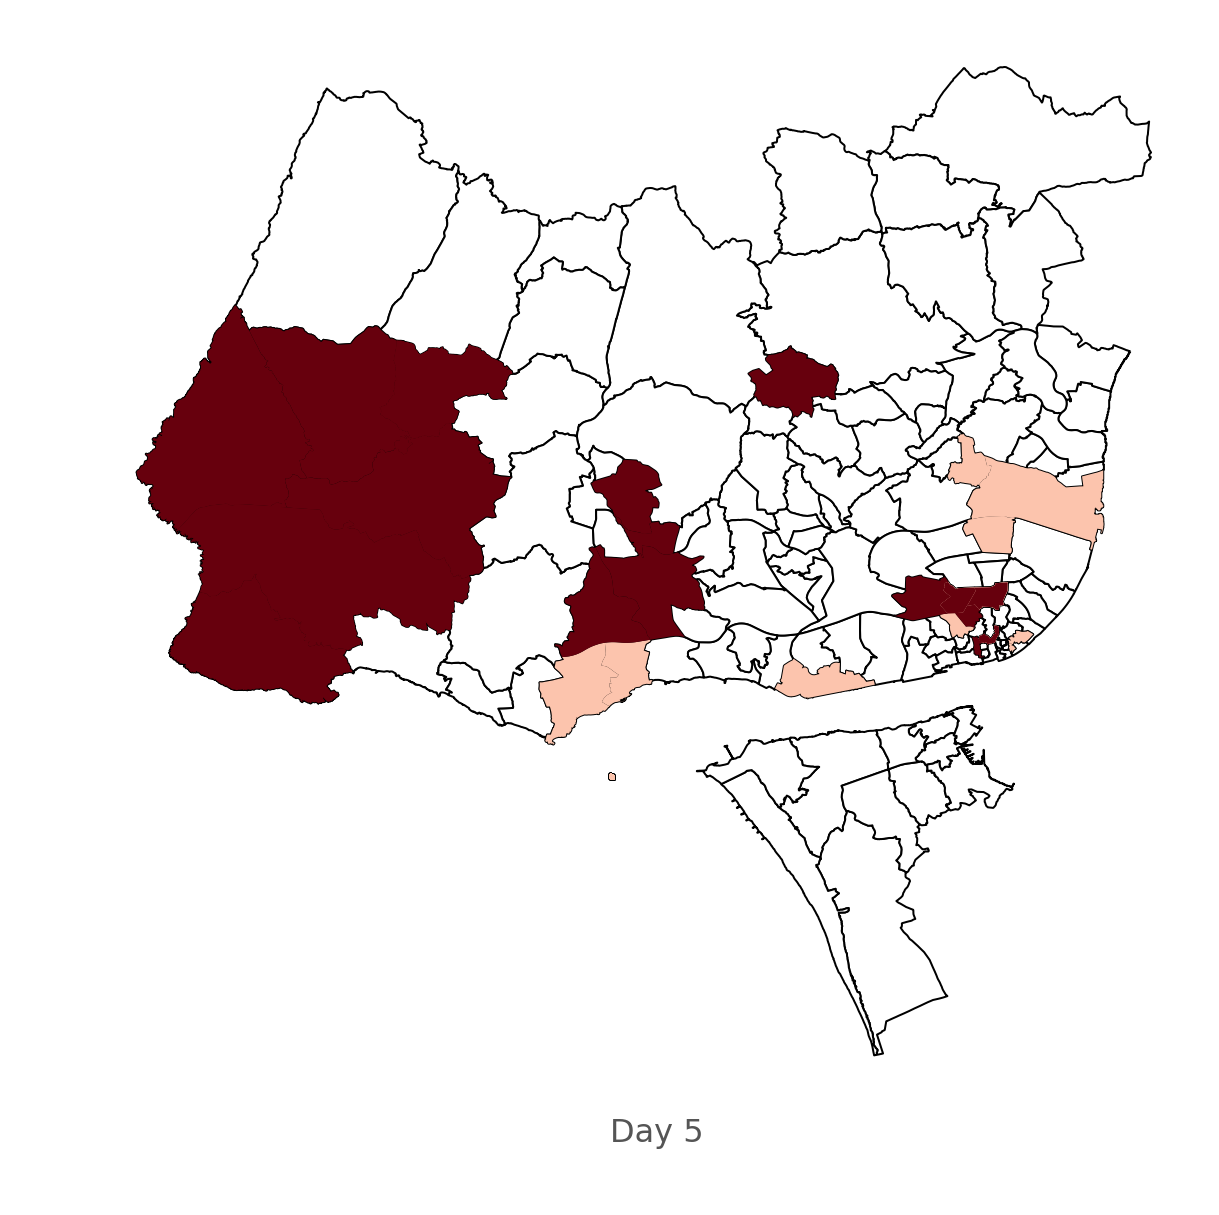

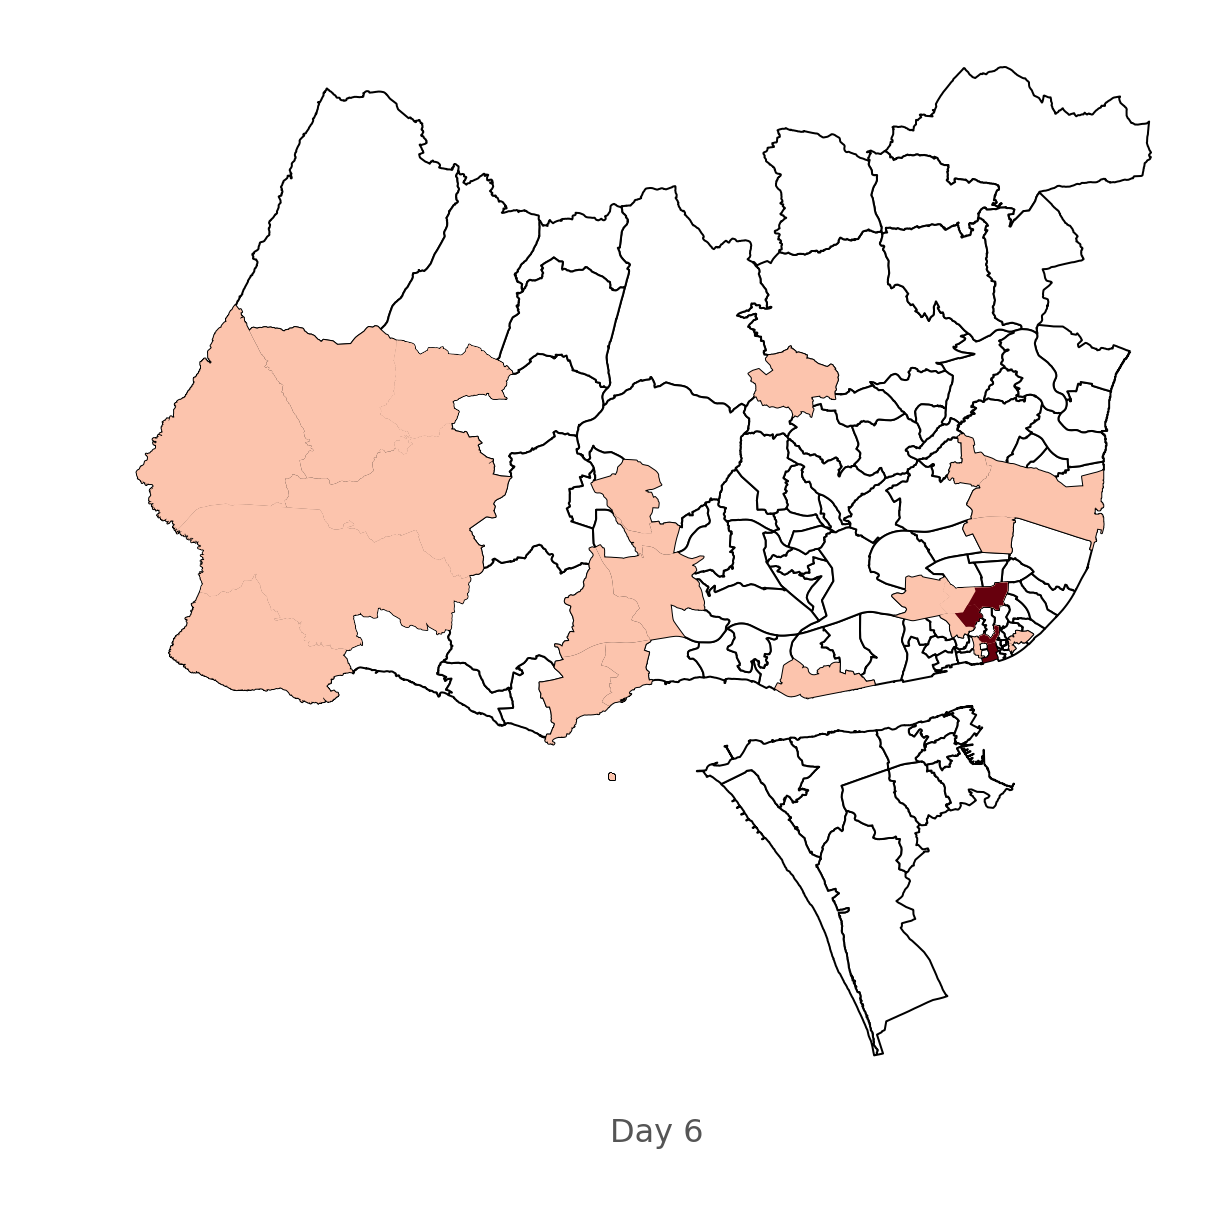

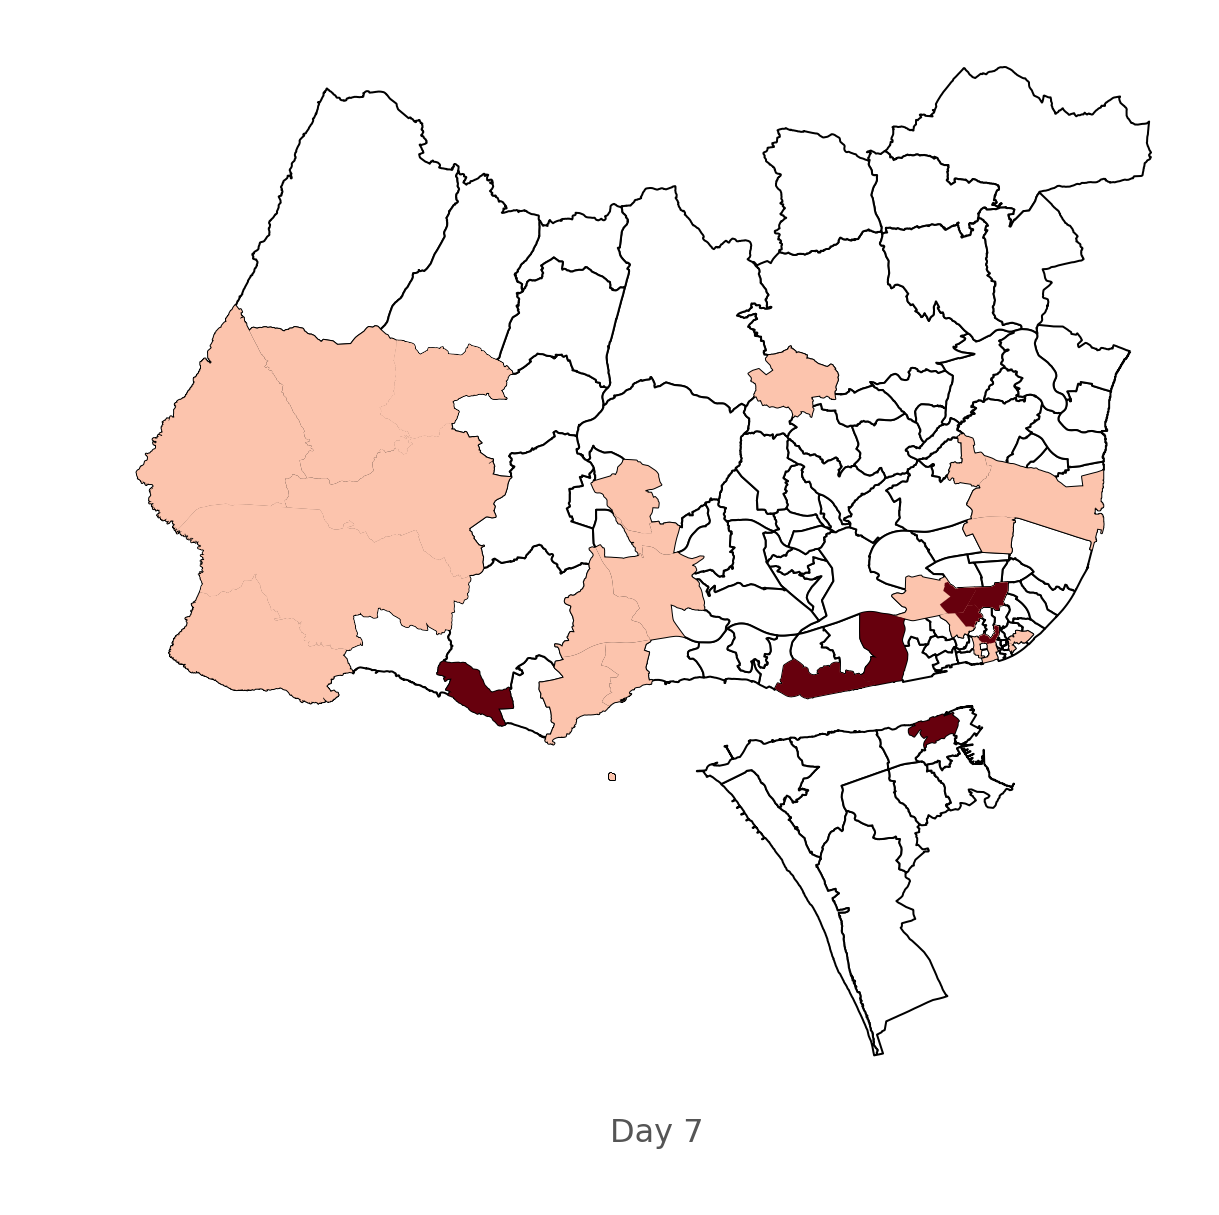

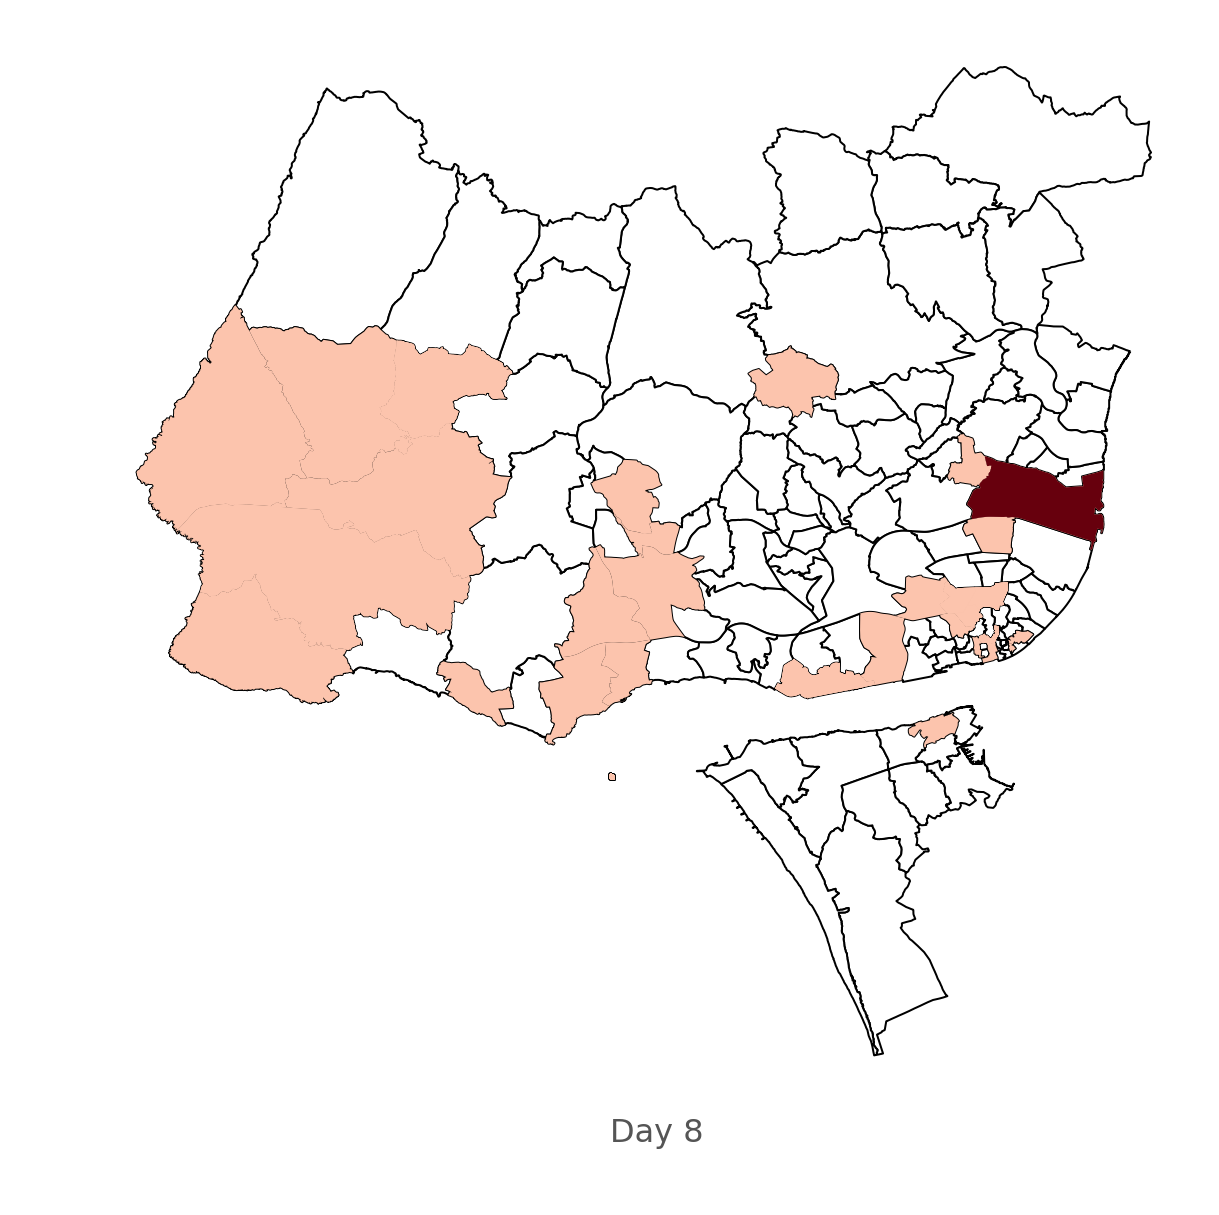

In [297]:
set_matplotlib_formats('retina')

couple['rel_count']=1

for day in list(range(min(couple.index.unique()),max(couple.index.unique())+1)):

    list_ = list(range(day))
    list_.remove(0)
    

    fig, ax1 = plt.subplots(ncols=1, figsize=(10, 10), sharex=True, sharey=True)
   
    # Plot
    portugal.plot(ax=ax1, color='white', edgecolor='black')
    if day != 1:
        if day != 2:
            #list_.remove(max(list_))
            couple.loc[list_].plot(ax=ax1, column='rel_count', cmap='Reds', vmin=-1, vmax=8)
            couple.loc[day].plot(ax=ax1, column='rel_day2', cmap='Reds', vmin=-1, vmax=day)
            
        else:
            couple.loc[1].plot(ax=ax1, column='rel_count', cmap='Reds', vmin=-1, vmax=8)
            couple.loc[2].plot(ax=ax1, column='rel_day2', cmap='Reds', vmin=-1, vmax=day)
    else:
        couple.loc[1].plot(ax=ax1, column='rel_day2', cmap='Reds', vmin=-2, vmax=day)

        

    #ax1.set_title('Data Stories: Two tourists in Lisbon', fontdict={'fontsize': 20, 'fontweight' : 3})
    ax1.annotate('Day %s' % (day), xy=(0.5, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=16, color='#555555')
    ax1.axis('off')



In [270]:
couple_story = pd.read_sql_query(query,con=connection)[['event_date','client_id','centroide_latitude','centroide_longitude','label']]
couple_story = couple_story[~couple_story['centroide_latitude'].isnull()]
couple_story = couple_story[~couple_story['client_id'].isnull()]
couple_story = couple_story.drop_duplicates()
couple_story['client_id'] = couple_story['client_id'].astype(int)
#couple_story['event_date'] = pd.to_datetime(couple_story['event_date'])
couple_story['day'] = couple_story['event_date'].dt.day
couple_story['hour'] = couple_story['event_date'].dt.hour
couple_story['minute'] = couple_story['event_date'].dt.minute
couple_story['rel_day'] = (couple_story['day'] - min(couple_story['day'])+1).astype(int)



In [280]:
places = couple_story.sort_values('event_date').groupby('rel_day')['label'].unique().to_frame()

print('Places visited each day (per order):')
for day in list(range(1,9)):
    print('Day %s:' % day, places.loc[day]['label'] )


Places visited each day (per order):
Day 1: ['Aeroporto de Lisboa' 'Eduardo VII Park']
Day 2: ['Marquês de Pombal' 'Eduardo VII Park' 'Rossio Square']
Day 3: ['Rato' 'Alfama' 'Fado Museum' 'Rossio Square' 'Marquês de Pombal'
 'Eduardo VII Park']
Day 4: ['Rossio Square' 'MAAT' 'Oeiras' 'Paço de Arcos']
Day 5: ['Quinta da Regaleira' 'Sintra' 'Colombo shopping center' 'Guincho'
 'Queluz National Palace' 'Oeiras' 'The Águas Livres Aqueduct'
 'Rossio Square' 'Marquês de Pombal' 'Eduardo VII Park'
 'Luís de Camões square']
Day 6: ['Santa Justa Lift' 'Marquês de Pombal' 'Rossio Square']
Day 7: ['Cristo Rei' 'MAAT' 'National Coach Museum' 'Carcavelos' 'Rossio Square'
 'Marquês de Pombal' 'Eduardo VII Park']
Day 8: ['Aeroporto de Lisboa']
